<a href="https://colab.research.google.com/github/tibayo1/Projects/blob/main/CoronaVirus_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data**

The data is from [Kaggle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)

# About the Code:

The code is structed such that a lot of attention is focused on the Train data. Most of the cleaning and visualization can be easily replicated on the Test Data.

Kindly check the comments to understand the insight of the cells.

In [ ]:
#Immport needed Libiraries 
import os
import json
import pandas as pd
import regex as re
import numpy as np
import seaborn as sns
import nltk; nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords
import math
import matplotlib.pyplot as plt
%matplotlib inline
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Getting data for Kaggle 
# read file
with open('/content/kaggle.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
#get username and key
kaggle_key = str(obj['key'])
kaggle_username = str(obj['username'])
# parse file
obj = json.loads(data)

os.environ['KAGGLE_USERNAME'] = kaggle_username # username from the json file
os.environ['KAGGLE_KEY'] = kaggle_key # key from the json file
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 72.0MB/s]


In [ ]:
#Unzipping the data to my_data
!unzip covid-19-nlp-text-classification.zip -d my_data 

Archive:  covid-19-nlp-text-classification.zip
  inflating: my_data/Corona_NLP_test.csv  
  inflating: my_data/Corona_NLP_train.csv  


**Exploratory Data for Training CSV**

In [ ]:
#Having a quick look at the first 5 test data from the CSV file.
train = pd.read_csv('/content/my_data/Corona_NLP_train.csv', encoding='ISO-8859-1')

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
#Drop the ScreeName and Username as it's not so useful and are stated as dummy variables.
train.drop(["ScreenName", "UserName"], axis=1, inplace=True) 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       32567 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [ ]:
#This it to know the exact number of postives, negative and so on. It could be normalize if further statistical are needed with (normalize=True)
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
#Replacing the Ext_Negative and Negative with the same value 1 and vice versa for Positive and Ext_Positive as 2 leaving Neutral as 0
train['Sentiment'].replace({'Neutral':0,'Extremely Negative':1,'Negative':1,'Positive':2,'Extremely Positive':2},inplace=True)

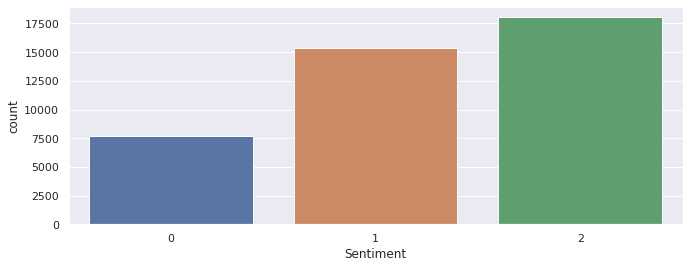

In [ ]:
#Ploting to know the distribution. From this plot, we can see that the postive tops the chart
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(x = "Sentiment", data = train)

In [ ]:
# Brief insight into the Location column of the data. For a start I left the NAN values to see them.
train_locate = train['Location'].value_counts(dropna = False)

# From observation of the data too, I decided to Split the commas from the location i.e (New York, NY)
train_Locate2 = train.Location.str.split(",").str[0]
train_locate 


NaN                            8590
London                          540
United States                   528
London, England                 520
New York, NY                    395
                               ... 
Odense, Danmark                   1
The Netherlands & worldwide       1
North Okanagan, B.C.              1
Preston, Lancashire (UK)          1
Everywhere You Are Not.           1
Name: Location, Length: 12221, dtype: int64

In [ ]:
train.describe()

,Sentiment
count,41157.000000
mean,1.251063
std,0.750235
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


Text(0.5, 1.0, 'Twitter locations')

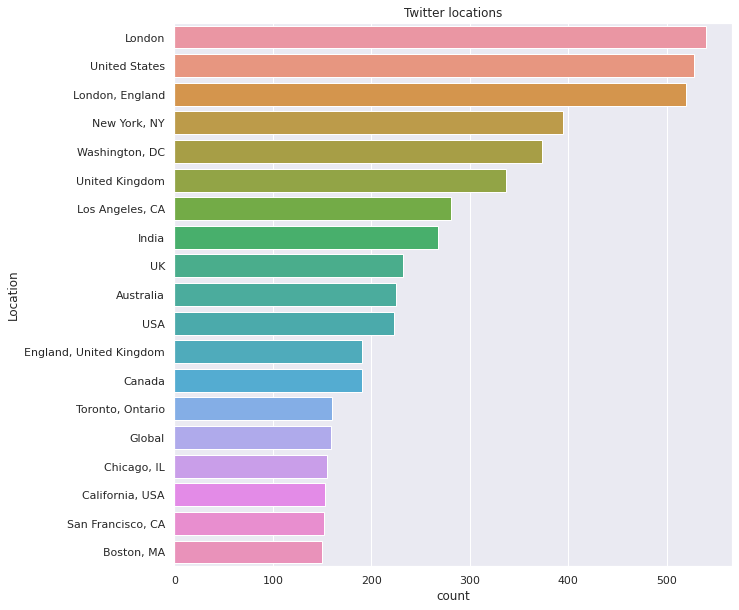

In [ ]:
#Haven done the needed cleaning, We arrange the Tweets based on the location from Highest to the Lowest 
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data = train,order = train_locate.iloc[1:20].index).set_title("Twitter locations")

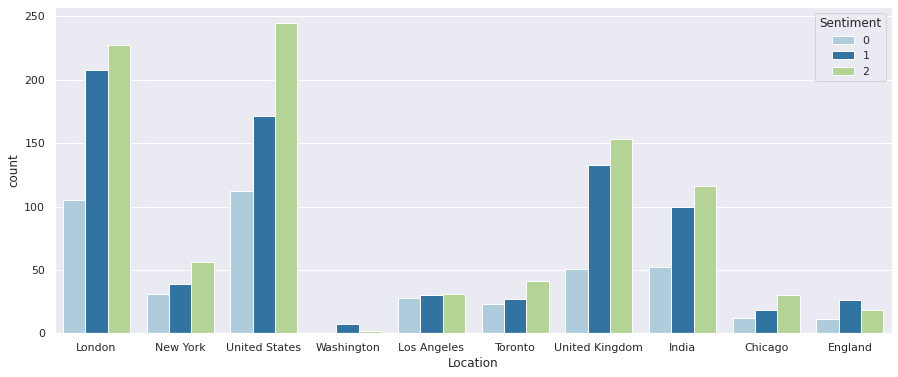

In [ ]:
#I try to find the visualize Location which has the most postive tweet and Negative tweets.  
#From our chart, United States has the most postive tweets and London has the most negative tweets.
#In this chart, I dropped the Nan values by using the splited train_Locate2 rather thatn train_locate which has the Nan values. 
loc_sent = train.iloc[:, [0,3]] 
plt.figure(figsize=(15, 6))
locse = sns.countplot(x = "Location", hue = "Sentiment", data = loc_sent, order = train_Locate2.value_counts()[:10].index, orient = "h", palette = "Paired")



**Cleaning the tweet**

In [ ]:
#stop_words = stopwords.words('english')
#To get useful information from the tweets, there's a need to clean tweeets from URLs, HTML, HASHTAGS, (@,$,£) SYMBOLS
#I create a function that does that to be used further for word cloud
def clean_data(twit):
    # Remove URLS
    twit = re.sub(r'http\S+', ' ', twit)
    
    #remove html
    
    twit = re.sub(r'<.*?>', " ",twit)
        
    #remove hastags
    
    twit = re.sub(r'#\w+',' ', twit)
    
    #remove mentioned
    
    twit = re.sub(r'@\w+',' ', twit)
    
    #remove money
    
    twit = re.sub(r'£|\$', 'money', twit)
   
    #remove stop words
    
    twit = twit.split()
    twit = " ".join([word for word in twit if not word in stop_words])
    
    
    return twit


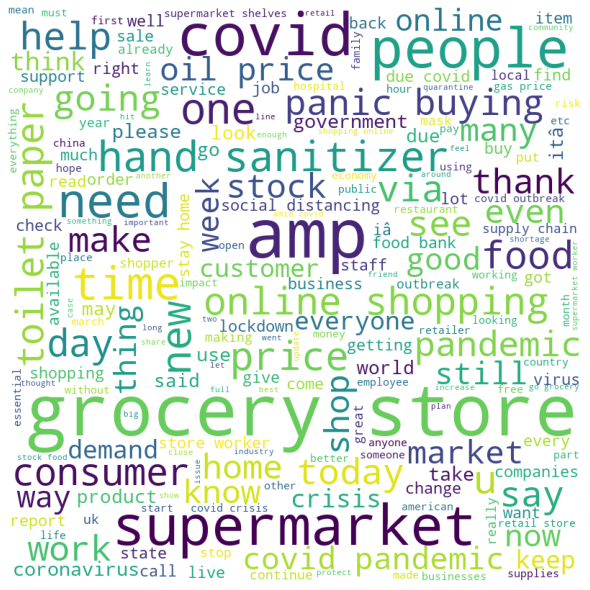

In [ ]:

train["text"] = train["OriginalTweet"].apply(clean_data)

comment_words = '' 
#stop_words = stopwords.words('english')
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train['text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Insight from the Word Cloud:

From the word cloud, we can see that a lot of words are seen evident in the tweets. Take for example **grocery store** this was definitely as a result of panic buying at the time of the COVID era. Another, **toilet paper** resulted from the point when grocery stores were running low on them. 

**Exploratory Data for Test CSV**

In [ ]:
#Having a quick look at the first 5 test data from the CSV file.
test = pd.read_csv('/content/my_data/Corona_NLP_test.csv')
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
#Drop the ScreeName and Username as it's not so useful and are stated as dummy variables.
test.drop(["ScreenName", "UserName"], axis=1, inplace=True) 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       2964 non-null   object
 1   TweetAt        3798 non-null   object
 2   OriginalTweet  3798 non-null   object
 3   Sentiment      3798 non-null   object
dtypes: object(4)
memory usage: 118.8+ KB


In [ ]:
#This it to know the exact number of postives, negative and so on. It could be normalize if further statistical are needed with (normalize=True)
test['Sentiment'].value_counts(normalize=True)

Negative              0.274092
Positive              0.249342
Neutral               0.162981
Extremely Positive    0.157715
Extremely Negative    0.155872
Name: Sentiment, dtype: float64

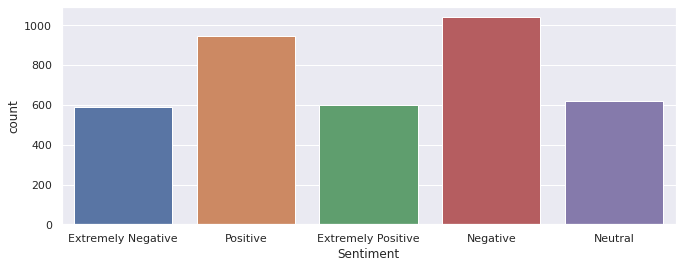

In [ ]:
#A plot to show the distribution 
sns.countplot(x = "Sentiment", data = test)

In [ ]:
test_locate = test['Location'].value_counts(dropna = False)
test_locate


NaN                              834
United States                     75
London, England                   48
Washington, DC                    38
New York, NY                      34
                                ... 
San Francisco, St. Paul            1
Westbrook, Alberta                 1
SD,CA                              1
Never Never Land                   1
At a wooden desk far far away      1
Name: Location, Length: 1718, dtype: int64

Text(0.5, 1.0, 'Twitter locations')

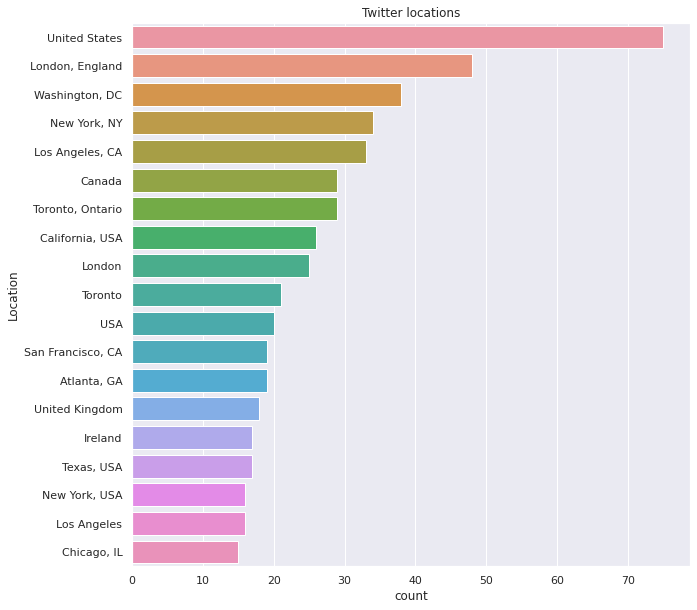

In [ ]:
#Location
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data = test ,order = test_locate.iloc[1:20].index).set_title("Twitter locations")